# HSE 2021: Mathematical Methods for Data Analysis


In [ ]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import *

from sklearn.metrics import *
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1.  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

Let's take an Derivative on w and w0. 

$$\nabla_w L = \frac{1}{N} \sum_{i=1}^N \frac{-y_ix_i*exp(-y_i(w_0+w^\top x_i))}{1+exp(-y_i(w_0+w^\top x_i))}+ \ sign(w)*gamma +2 \beta w$$.

$$\nabla_{w0} L = \frac{1}{N} \sum_{i=1}^N \frac{-y_i*exp(-y_i(w_0+w^\top x_i))}{1+exp(-y_i(w_0+w^\top x_i))}$$.

#### 2.  Implement the Elastic Net loss (as a function)

In [ ]:
import math
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  l1 = 0
  l2 = 0
  sum = 0
  N = len(X)
  
  for i in range(len(w)):
    l1 += abs(w[i])
    l2 += pow(abs(w[i]),2)
  l1 *= gamma
  l2 *= beta
  for i in range(N):
    sum += math.log(1+math.exp(-y[i]*(np.dot(w,X[i])+w0))) + l1 + l2
    
  return (1/N)*sum

#### 3.  Implement the gradient (as a function)

In [ ]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
  N = len(X)
  for i in range(N):
    extra = (math.exp(-y[i]*(w0+np.dot(w,X[i])) )  ) / (1+math.exp(-y[i]*(w0+np.dot(w,X[i])) ) )
    if i == 0:
      grad_w0 = extra * (-y[i])
      grad_w = extra * (-y[i]*X[i])+np.sign(w)*gamma + 2*beta*w
    else:
      grad_w0 += extra * (-y[i])
      grad_w += extra * (-y[i]*X[i])+np.sign(w)*gamma + 2*beta*w
  grad_w0 /= N
  grad_w /= N
  print(grad_w)
  print(grad_w0)
  return grad_w, grad_w0

#### Check yourself

In [ ]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]
-0.20782319347690742


####  4.  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):  
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w0 = None
        self.w = None
        self.w_history = None
        self.w0_history = None
        self.loss_history = None
        self.i_hist = None
        
    def fit(self, X, y):
        self.loss_history = []
        self.w_history = []
        self.w0_history = []
        self.i_hist = []
        self.w, self.w0 = np.random.normal(size=len(X[0])), np.random.normal()
        
        for i in range(self.max_iter):
          self.i_hist.append(i)
          w_grad, w0_grad = get_grad(X,y,self.w,self.w0, self.gamma, self.beta)
          w_prev = self.w
          w0_prev = self.w0
          self.w = self.w - self.learning_rate*w_grad
          self.w0 = self.w0 - self.learning_rate*w0_grad
          loss_res = loss(X,y,self.w,self.w0, self.gamma, self.beta)

          print('Iteration: ', i, ' Loss: ', loss_res)

          self.loss_history.append(loss_res)
          self.w_history.append(self.w)
          self.w0_history.append(self.w0)
          if (np.linalg.norm(w_prev - self.w) < self.tolerance) and (abs(w0_prev - self.w0) < self.tolerance):
            print('yes: ', np.linalg.norm(w_prev - self.w), '<',self.tolerance)
            return self
        return self
    
    def predict(self, X):
       arr = self.predict_proba(X)
       res = []
       print('predict',arr)
       for i in range(len(X)):
         if arr[0,i] > arr[1,i]:
           res.append(0)
         else:
           res.append(1)
       res = np.array(res)
       return res
        
    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)),\
                         1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])

In [ ]:
# sample data to test model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [ ]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    print(ypred)
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

Выходные данные были обрезаны до нескольких последних строк (5000).
[-4.11877704e-05 -4.25618823e-05]
6.601013144712808e-05
Iteration:  13335  Loss:  0.1002543353655101
[-4.11730181e-05 -4.25466489e-05]
6.598649905602815e-05
Iteration:  13336  Loss:  0.10025433457968555
[-4.11582711e-05 -4.25314210e-05]
6.596287518379925e-05
Iteration:  13337  Loss:  0.10025433379442354
[-4.11435294e-05 -4.25161986e-05]
6.593925982737845e-05
Iteration:  13338  Loss:  0.10025433300972374
[-4.11287930e-05 -4.25009816e-05]
6.591565298356482e-05
Iteration:  13339  Loss:  0.1002543322255857
[-4.11140619e-05 -4.24857702e-05]
6.589205464933218e-05
Iteration:  13340  Loss:  0.10025433144200904
[-4.10993361e-05 -4.24705642e-05]
6.586846482151869e-05
Iteration:  13341  Loss:  0.10025433065899328
[-4.10846157e-05 -4.24553637e-05]
6.584488349703007e-05
Iteration:  13342  Loss:  0.10025432987653815
[-4.10699006e-05 -4.24401687e-05]
6.582131067274578e-05
Iteration:  13343  Loss:  0.10025432909464319
[-4.10551907e-05

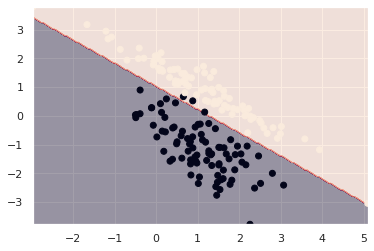

In [ ]:
model = Logit(0.001,0.001,1e-1,1e-6,15000)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5.  Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

     w0_values  w1_values  w2_values  loss_values  iteration
0     0.818187  -1.097186  -1.113838     1.480553          0
1     0.823707  -1.087003  -1.034037     1.416526          1
2     0.829042  -1.075831  -0.956876     1.356435          2
3     0.834154  -1.063724  -0.882398     1.300191          3
4     0.839011  -1.050750  -0.810620     1.247663          4
..         ...        ...        ...          ...        ...
995  -2.376113   2.187093   3.104401     0.123974        995
996  -2.377539   2.188028   3.105221     0.123939        996
997  -2.378963   2.188961   3.106040     0.123903        997
998  -2.380386   2.189894   3.106858     0.123867        998
999  -2.381808   2.190825   3.107675     0.123832        999

[1000 rows x 5 columns]


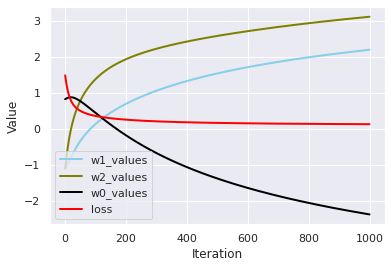

In [ ]:
#here i decided to show the dependence for the first 1000 steps, because it is
#much more clear (in comparison with all steps (for about 15 thousands))

model.w_history = np.array(model.w_history)
model.w0_history = np.array(model.w0_history)
model.loss_history = np.array(model.loss_history)
# loading necessary data to dataframe
df=pd.DataFrame({'w0_values': model.w0_history[:1000],
                 'w1_values': model.w_history[:1000,0], 
                 'w2_values': model.w_history[:1000,1], 
                 'loss_values': model.loss_history[:1000],
                 'iteration': model.i_hist[:1000] })
print(df)

plt.plot('iteration','w1_values', data=df, marker='', color='skyblue', linewidth=2, label = "w1_values")
plt.plot( 'iteration','w2_values', data=df, marker='', color='olive', linewidth=2, label = "w2_values")
plt.plot( 'iteration','w0_values', data=df, marker='', color='black', linewidth=2, label = "w0_values")
plt.plot('iteration','loss_values', data=df, marker='', color='red', linewidth=2, label="loss")

plt.xlabel('Iteration')
plt.ylabel('Value')

plt.plot()
plt.legend()
plt.show()


## PART 2: Support Vector Machines

#### 6. Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [ ]:
def show_results(test_y, pred, proba):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
    print('\n')
    labels = ['negative','positive']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

As far as i saw, that GridSearch with all parameters was working for a very long period of time - i decided to separate gridSearch for 3 kernels(with their parameters). And after that watch to all metrics and find the best kernel between them. 

Fitting 2 folds for each of 7 candidates, totalling 14 fits
[CV] C=0.001, kernel=linear ..........................................
[CV] ........................... C=0.001, kernel=linear, total=   0.0s
[CV] C=0.001, kernel=linear ..........................................
[CV] ........................... C=0.001, kernel=linear, total=   0.0s
[CV] C=0.01, kernel=linear ...........................................
[CV] ............................ C=0.01, kernel=linear, total=   0.0s
[CV] C=0.01, kernel=linear ...........................................
[CV] ............................ C=0.01, kernel=linear, total=   0.0s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=   0.0s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished


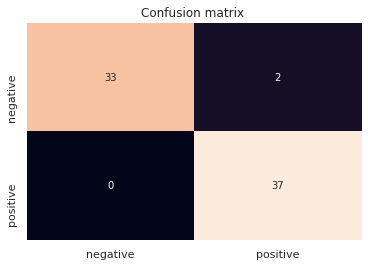

In [ ]:

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.4, random_state=0)

parameters_linear = {'kernel':['linear'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svr = SVC(probability=True, verbose = False)

clf_linear = GridSearchCV(svr, parameters_linear, scoring = 'f1', verbose=2, cv=2)
clf_linear.fit(x_train, y_train)
print('BEST PARAMS: ', clf_linear.best_params_)
pred = clf_linear.predict(x_test)
proba  = clf_linear.predict_proba(x_test)
show_results(y_test, pred, proba)

Fitting 2 folds for each of 28 candidates, totalling 56 fits
[CV] C=0.001, degree=1, kernel=poly ..................................
[CV] ................... C=0.001, degree=1, kernel=poly, total=   0.0s
[CV] C=0.001, degree=1, kernel=poly ..................................
[CV] ................... C=0.001, degree=1, kernel=poly, total=   0.0s
[CV] C=0.001, degree=4, kernel=poly ..................................
[CV] ................... C=0.001, degree=4, kernel=poly, total=   0.0s
[CV] C=0.001, degree=4, kernel=poly ..................................
[CV] ................... C=0.001, degree=4, kernel=poly, total=   0.0s
[CV] C=0.001, degree=8, kernel=poly ..................................
[CV] ................... C=0.001, degree=8, kernel=poly, total=   0.0s
[CV] C=0.001, degree=8, kernel=poly ..................................
[CV] ................... C=0.001, degree=8, kernel=poly, total=   0.0s
[CV] C=0.001, degree=10, kernel=poly .................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=10, degree=4, kernel=poly, total=   0.0s
[CV] C=10, degree=8, kernel=poly .....................................
[CV] ...................... C=10, degree=8, kernel=poly, total=   0.0s
[CV] C=10, degree=8, kernel=poly .....................................
[CV] ...................... C=10, degree=8, kernel=poly, total=   0.2s
[CV] C=10, degree=10, kernel=poly ....................................
[CV] ..................... C=10, degree=10, kernel=poly, total=   0.0s
[CV] C=10, degree=10, kernel=poly ....................................
[CV] ..................... C=10, degree=10, kernel=poly, total=   0.1s
[CV] C=100, degree=1, kernel=poly ....................................
[CV] ..................... C=100, degree=1, kernel=poly, total=   0.0s
[CV] C=100, degree=1, kernel=poly ....................................
[CV] ..................... C=100, degree=1, kernel=poly, total=   0.0s
[CV] C=100, degree=4, kernel=poly ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:  1.1min finished


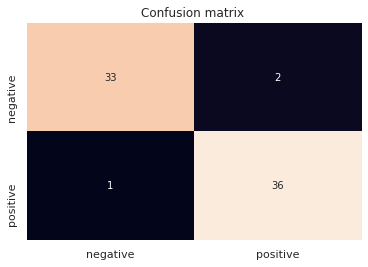

In [ ]:
parameters_poly = {'kernel':['poly'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'degree':[1, 4, 8, 10]}
clf_poly = GridSearchCV(svr, parameters_poly, scoring = 'f1', verbose=2, cv=2)
clf_poly.fit(x_train, y_train)
print('BEST PARAMS: ', clf_poly.best_params_)
pred = clf_poly.predict(x_test)
proba  = clf_poly.predict_proba(x_test)
show_results(y_test, pred, proba)

Fitting 2 folds for each of 21 candidates, totalling 42 fits
[CV] C=0.001, gamma=0, kernel=rbf ....................................
[CV] ..................... C=0.001, gamma=0, kernel=rbf, total=   0.0s
[CV] C=0.001, gamma=0, kernel=rbf ....................................
[CV] ..................... C=0.001, gamma=0, kernel=rbf, total=   0.0s
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ..................... C=0.001, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ..................... C=0.001, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.001, gamma=10, kernel=rbf ...................................
[CV] .................... C=0.001, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.001, gamma=10, kernel=rbf ...................................
[CV] .................... C=0.001, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=0, kernel=rbf .....................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=0, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=0, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] ...................... C=0.1, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] ...................... C=0.1, gamma=10, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0, kernel=rbf ........................................
[CV] ......................... C=1, gamma=0, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0, kernel=rbf ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.2s finished


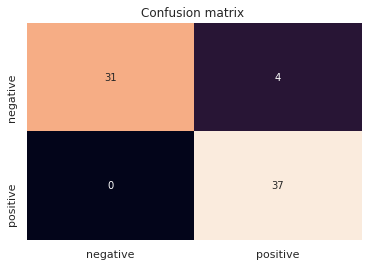

In [ ]:
parameters_rbf = {'kernel':['rbf'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0,1,10]}
clf_rbf = GridSearchCV(svr, parameters_rbf, scoring = 'f1', verbose=2, cv=2)
clf_rbf.fit(x_train, y_train)
print('BEST PARAMS: ', clf_rbf.best_params_)
pred = clf_rbf.predict(x_test)
proba  = clf_rbf.predict_proba(x_test)
show_results(y_test, pred, proba)

So now we have all best params and metrics for 3 kernels: poly, linear and rbf. 

BEST PARAMS:  {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

Precision:   0.95

Recall:   0.94

F1-measure:   0.94

Accuracy:   0.94

ROC-AUC  =    1.00


BEST PARAMS:  {'C': 1, 'degree': 1, 'kernel': 'poly'}

Precision:   0.96

Recall:   0.96

F1-measure:   0.96

Accuracy:   0.96

ROC-AUC  =    1.00

BEST PARAMS:  {'C': 10, 'kernel': 'linear'}

Precision:   0.97

Recall:   0.97

F1-measure:   0.97

Accuracy:   0.97

ROC-AUC  =    1.00

Now we can see, that for our data the worst kernel is rbf with its 0,94 accurancy. The second place takes polynomial kernel with 0,97 accurancy/F1-measure. And the best kernel for our model is linear with param C = 10. 

Now we will draw the plots for each kernel in case of their hyperparameters. 

In [ ]:
#to make the plot more clear  i use only first three lines from data
def drawPlot(data,ttl,prm):
  plt.plot('param','f1_scores', data=data.iloc[:4], marker='', color='skyblue', linewidth=2, label = "f1_scores")
  plt.plot( 'param','acc_scores', data=data.iloc[:4], marker='', color='olive', linewidth=2, label = "acc_scores")
  plt.plot( 'param','roc_scores', data=data.iloc[:4], marker='', color='black', linewidth=2, label = "roc_scores")

  plt.xlabel(prm)
  plt.ylabel('Value')

  plt.plot()
  plt.title(ttl)
  plt.legend()
  plt.show()

In [ ]:
#for plots construction

param_C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
f1_scores_linear = []
acc_scores_linear = []
roc_scores_linear = []
for i in range(7):
  parameters_linear = {'kernel':['linear'], 'C':[param_C[i]]}
  clf_linear = GridSearchCV(svr, parameters_linear, scoring = 'f1', verbose=2, cv=2)
  clf_linear.fit(x_train, y_train)
  pred = clf_linear.predict(x_test)
  proba  = clf_linear.predict_proba(x_test)
  f1_scores_linear.append(f1_score(y_test, pred, average='macro'))
  acc_scores_linear.append(accuracy_score(y_test, pred))
  roc_scores_linear.append(roc_auc_score(y_test, proba[:,1]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] C=0.001, kernel=linear ..........................................
[CV] ........................... C=0.001, kernel=linear, total=   0.0s
[CV] C=0.001, kernel=linear ..........................................
[CV] ........................... C=0.001, kernel=linear, total=   0.0s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] C=0.01, kernel=linear ...........................................
[CV] ............................ C=0.01, kernel=linear, total=   0.0s
[CV] C=0.01, kernel=linear ...........................................
[CV] ............................ C=0.01, kernel=linear, total=   0.0s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=   0.0s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

In [ ]:
df_linear = pd.DataFrame({'f1_scores': f1_scores_linear,
                 'acc_scores': acc_scores_linear, 
                 'roc_scores': roc_scores_linear, 
                 'param': param_C })

   f1_scores  acc_scores  roc_scores     param
0   0.327103    0.486111    0.118147     0.001
1   0.902307    0.902778    0.959846     0.010
2   0.944272    0.944444    0.996911     0.100
3   0.958261    0.958333    0.998456     1.000
4   0.972136    0.972222    0.999228    10.000
5   0.972136    0.972222    1.000000   100.000
6   0.986087    0.986111    1.000000  1000.000


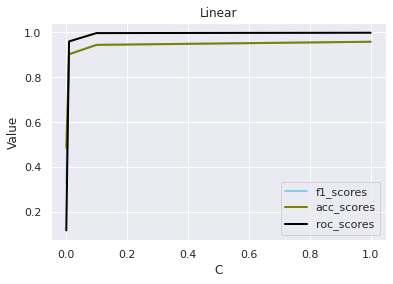

In [ ]:
print(df_linear)
drawPlot(df_linear,'Linear','C')

Here we can see that increasing of parameter C (which is actually regularization coefficient) influences the increase of all metrics. 

In [ ]:
param_degree = [1, 4, 8, 10]
f1_scores_poly = []
acc_scores_poly = []
roc_scores_poly = []
param_deg_history_poly = []
for j in range(len(param_degree)):
    parameters_poly = {'kernel':['poly'], 'C':[10], 'degree':[param_degree[j]]}
    clf_poly = GridSearchCV(svr, parameters_poly, scoring = 'f1', verbose=2, cv=2)
    clf_poly.fit(x_train, y_train)
    pred = clf_poly.predict(x_test)
    proba  = clf_poly.predict_proba(x_test)
    f1_scores_poly.append(f1_score(y_test, pred, average='macro'))
    acc_scores_poly.append(accuracy_score(y_test, pred))
    roc_scores_poly.append(roc_auc_score(y_test, proba[:,1]))
    param_deg_history_poly.append(param_degree[j])


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] C=10, degree=1, kernel=poly .....................................
[CV] ...................... C=10, degree=1, kernel=poly, total=   0.0s
[CV] C=10, degree=1, kernel=poly .....................................
[CV] ...................... C=10, degree=1, kernel=poly, total=   0.0s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] C=10, degree=4, kernel=poly .....................................
[CV] ...................... C=10, degree=4, kernel=poly, total=   0.0s
[CV] C=10, degree=4, kernel=poly .....................................
[CV] ...................... C=10, degree=4, kernel=poly, total=   0.0s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] C=10, degree=8, kernel=poly .....................................
[CV] ...................... C=10, degree=8, kernel=poly, total=   0.0s
[CV] C=10, degree=8, kernel=poly .....................................
[CV] ...................... C=10, degree=8

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] C=10, degree=10, kernel=poly ....................................
[CV] ..................... C=10, degree=10, kernel=poly, total=   0.0s
[CV] C=10, degree=10, kernel=poly ....................................
[CV] ..................... C=10, degree=10, kernel=poly, total=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


In [ ]:
df_Poly = pd.DataFrame({'f1_scores': f1_scores_poly,
                 'acc_scores': acc_scores_poly, 
                 'roc_scores': roc_scores_poly, 
                 'param': param_deg_history_poly })

   f1_scores  acc_scores  roc_scores  param
0   0.972201    0.972222    0.998456      1
1   0.986087    0.986111    0.984556      4
2   0.859375    0.861111    0.970656      8
3   0.784646    0.791667    0.033205     10


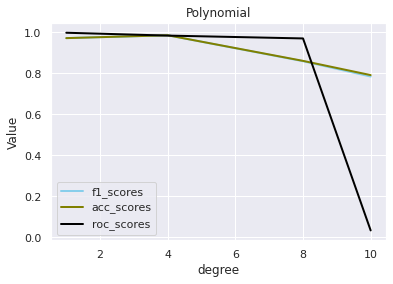

In [ ]:
print(df_Poly)
drawPlot(df_Poly,'Polynomial','degree')

This plot shows that our param degree for polynomial kernel has the danger of overfitting because as far as it increases - we can watch some kind of increase of accurancy and f1 metrics. But after it reaches the value = 4 all metrics start to decrease very sharp. 

In [ ]:
param_gamma = [1, 4, 8, 10]
f1_scores_rbf = []
acc_scores_rbf = []
roc_scores_rbf = []
for j in range(len(param_degree)):
    parameters_poly = {'kernel':['poly'], 'C':[0.01], 'gamma':[param_gamma[j]]}
    clf_poly = GridSearchCV(svr, parameters_poly, scoring = 'f1', verbose=2, cv=2)
    clf_poly.fit(x_train, y_train)
    pred = clf_poly.predict(x_test)
    proba  = clf_poly.predict_proba(x_test)
    f1_scores_rbf.append(f1_score(y_test, pred, average='macro'))
    acc_scores_rbf.append(accuracy_score(y_test, pred))
    roc_scores_rbf.append(roc_auc_score(y_test, proba[:,1]))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] C=0.01, gamma=1, kernel=poly ....................................
[CV] ..................... C=0.01, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.01, gamma=1, kernel=poly ....................................
[CV] ..................... C=0.01, gamma=1, kernel=poly, total=   0.0s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] C=0.01, gamma=4, kernel=poly ....................................
[CV] ..................... C=0.01, gamma=4, kernel=poly, total=   0.0s
[CV] C=0.01, gamma=4, kernel=poly ....................................
[CV] ..................... C=0.01, gamma=4, kernel=poly, total=   0.0s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] C=0.01, gamma=8, kernel=poly ....................................
[CV] ..................... C=0.01, gamma=8, kernel=poly, total=   0.0s
[CV] C=0.01, gamma=8, kernel=poly ....................................
[CV] ..................... C=0.01, gamma=8

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


In [ ]:
df_Rbf = pd.DataFrame({'f1_scores': f1_scores_rbf,
                 'acc_scores': acc_scores_rbf, 
                 'roc_scores': roc_scores_rbf, 
                 'param': param_gamma })

   f1_scores  acc_scores  roc_scores  param
0   0.986108    0.986111    0.974131      1
1   0.986108    0.986111    0.975290      4
2   0.986108    0.986111    0.979923      8
3   1.000000    1.000000    1.000000     10


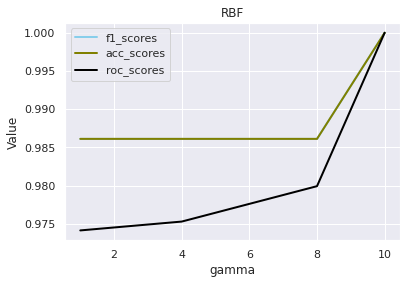

In [ ]:
print(df_Rbf)
drawPlot(df_Rbf,'RBF','gamma')

And at the last plot we see that for rbf kernel the increase of gamma from 8 to 10 shows the best influence on metrics. 

## PART 3: Natural Language Processing

#### 7. Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 100
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

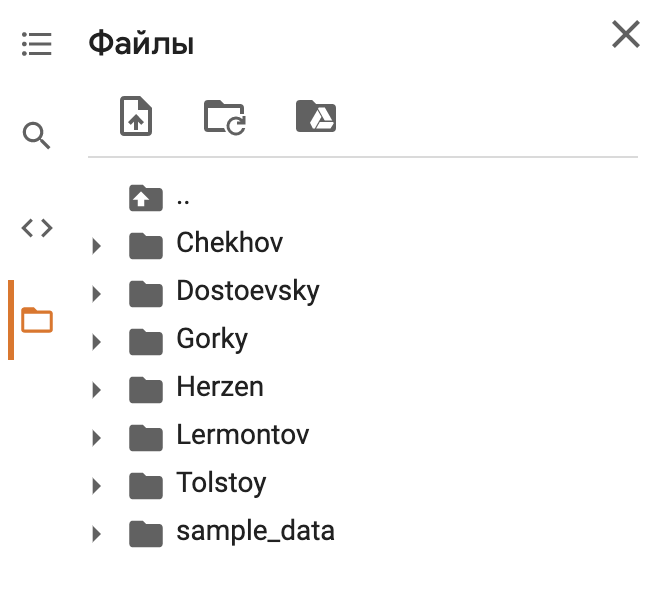

In [ ]:
! pip install pymorphy2

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 8.2MB 8.0MB/s 


In [ ]:
from os import listdir
import nltk
import string 
from nltk.tokenize import sent_tokenize, word_tokenize
import random
import pymorphy2 

In [ ]:
# We need to have folders with chosen by me authors: Tolstoy, Chekhov,
# Herzen, Gorky, Dostoevsky, Lermontov in our current directory
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')
nltk.download('punkt')
random.seed(42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# I've decided to remove all stop_words, digits and transform words to lower keys in the first step
# so final dataFrame will contain sentences with no stop_words and digit (etc)
# lemmatization i'll use on the second step

authors = ["Dostoevsky","Tolstoy","Gorky","Chekhov", "Herzen", "Lermontov"]
final_arr = []
for i in range(len(authors)):
  arr = []
  for elem in listdir(authors[i]):
    print(elem)
    if (elem.rfind('.txt') != -1):
      with open(authors[i]+'/'+elem) as f:
        extra = f.read().replace('!', '.').replace('?', '.').split('.')
        for j in extra:
          if len(j) > 15:
            str_extra = ''
            j = j.lower()
            for k in word_tokenize(j):
              if k not in stop_words and k not in string.punctuation and not k.isdigit():
                str_extra += k + ' '
            arr.append([str_extra.strip(' '), authors[i]])
  print("Number of possible sentences: ", len(arr))
  sent = pd.Series(arr)
  if arr[0][1] == 'Dostoevsky':
    arr = sent.sample(n = 40000)
  elif arr[0][1] == 'Tolstoy':
    arr = sent.sample(n = 30000)
  elif arr[0][1] == 'Gorky':
    arr = sent.sample(n = 20000)
  elif arr[0][1] == 'Chekhov':
    arr = sent.sample(n = 15000)
  elif arr[0][1] == 'Herzen':
    arr = sent.sample(n = 7000)
  elif arr[0][1] == 'Lermontov':
    arr = sent.sample(n = 3000)
  for k in arr:
    final_arr.append(k)
df = pd.DataFrame(final_arr, columns=['sentence', 'author'])
print(df)


In [ ]:
df[df['author'] == 'Tolstoy'].count()

sentence    0
author      0
dtype: int64

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
for s in df.iloc[:,0]:
  extra = s.split(' ')
  s_new = ''
  for w in extra:
    w_lemm = morph.parse(w)[0].normal_form
    s_new += w_lemm + ' '
    print(w,'-',w_lemm)
  s_new_to_arr = s_new.strip(' ')
  df['sentence'].replace({s: s_new_to_arr}, inplace=True)
print (df)
  

повторяю - повторять
сведется - свестись
одну - один
точку - точка
речи - речь
прокурора - прокурор
которой - который
перейду - перейти
– - –
мучила - мучить
целые - целый
пять - пять
лет - год
отпускала - отпускать
последнее - последний
слишком - слишком
тяжело - тяжело
мучился - мучиться
— - —
генерал - генерал
— - —
отвечал - отвечать
нестерпимым - нестерпимый
спокойствием - спокойствие
— - —
заарестовать - заарестовать
буйство - буйство
прежде - прежде
совершения - совершение
буйства - буйство
катя - катя
паша - паша
– - –
увидала - увидать
дверях - дверь
своих - свой
девушек - девушка
– - –
подите - пойти
сюда - сюда
замуж - замуж
выхожу - выходить
слышали - слышать
выдают - выдавать
-- - --
промычал - промычать
фома - фома
нос - нос
казался - казаться
очень - очень
усталым - усталый
изредка - изредка
хмурился - хмуриться
нисколько - нисколько
находил - находить
нужным - нужный
скрывать - скрывать
свое - свой
неприятное - неприятный
расположение - расположение
духа - дух
могу - мо

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
train_sentence, test_sentence, train_author, test_author = train_test_split(df.iloc[:,0], df.iloc[:,1], test_size=0.2, random_state=42, stratify = df.iloc[:,1])

In [ ]:
vectorizer = CountVectorizer(max_features = 150000)
vectorizer.fit(train_sentence)

vectorizer.get_feature_names()[:150000]

In [ ]:
train_S = vectorizer.transform(train_sentence)
test_S  = vectorizer.transform(test_sentence)

In [ ]:
train_S.todense()[:2]

In [ ]:
vectorizer = TfidfVectorizer(max_features = 150000) 
vectorizer.fit(train_sentence)

vectorizer.get_feature_names()[:150000]

In [ ]:
train_S_tf_idf = vectorizer.transform(train_sentence)
test_S_tf_idf  = vectorizer.transform(test_sentence)

In [ ]:
train_S_tf_idf.todense()[:2]

So now we can see, that after vectorizing sentences with bag-of-words we have matrix, there for each word from max_features we see how many times it appears in the current sentence. So we have frequency occurrence matrix. 

In the same time we can take a look to tf-idf matrix, where we see float numbers, which show us frequency of occurrence of a word in the current sentence. So it is the ratio of the number of mentions of a word to the sum of all words. 

#### 7. Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. 

I've decided to increase our number of samples in data for more clear plot. 

In [ ]:

from sklearn.datasets import make_classification
X_new, y_new = make_classification(n_samples=5000, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

Fitting 2 folds for each of 7 candidates, totalling 14 fits
[CV] C=0.001, kernel=linear ..........................................
[CV] ........................... C=0.001, kernel=linear, total=   0.1s
[CV] C=0.001, kernel=linear ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ........................... C=0.001, kernel=linear, total=   0.1s
[CV] C=0.01, kernel=linear ...........................................
[CV] ............................ C=0.01, kernel=linear, total=   0.1s
[CV] C=0.01, kernel=linear ...........................................
[CV] ............................ C=0.01, kernel=linear, total=   0.1s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=   0.0s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=   0.1s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=   0.1s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=   0.1s
[CV] C=10, kernel=linear .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    8.4s finished


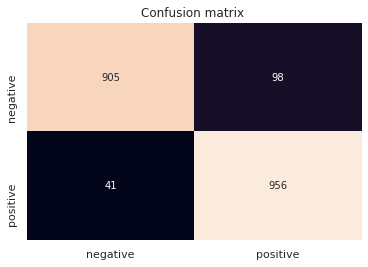

In [ ]:

x_train_new, x_test_new, y_train_new, y_test_new = sklearn.model_selection.train_test_split(X_new, y_new, test_size=0.4, random_state=0)

parameters_linear = {'kernel':['linear'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svr = SVC(probability=True, verbose = False)

clf_linear_new = GridSearchCV(svr, parameters_linear, scoring = 'f1', verbose=2, cv=2)
clf_linear_new.fit(x_train_new, y_train_new)
print('BEST PARAMS: ', clf_linear.best_params_)
pred = clf_linear_new.predict(x_test_new)
proba  = clf_linear_new.predict_proba(x_test_new)
show_results(y_test_new, pred, proba)

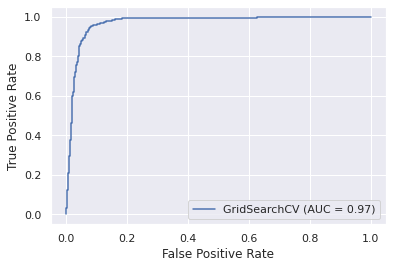

In [ ]:
sklearn.metrics.plot_roc_curve(clf_linear_new, x_test_new, y_test_new)  
plt.show()  

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_new, pred, pos_label=1)
print(fpr)
print(tpr)
print(thresholds)

[0.         0.09770688 1.        ]
[0.         0.95887663 1.        ]
[2 1 0]


Each point at the plot is coordinate of (FPR,TPR) which responds to value of threshold. As close we are to the point (1,1) - as better. 